In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import os
import datetime
import random

from datetime import datetime as dt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def fix_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
fix_seed(256)

Data Load

In [2]:
data_path = "/root/storage/etri_lifelog/user01-06/user06"
dir_list = os.listdir(data_path)

user_all_data = []

for item in dir_list:
    csv_file = data_path + "/" + item + "/" + item + "_label.csv"
    rdr = pd.read_csv(csv_file)
    user_all_data.append(rdr)

#df_all : 전체 data
df_all = pd.concat(user_all_data, axis=0)
df_all['ts']=pd.to_datetime(df_all['ts'], unit='s')
df_all['is_weekend']=df_all.apply(lambda x: x['ts'].weekday()>=5, axis=1)
df_all['ampm']=df_all.apply(lambda x: ["AM","PM"][x['ts'].hour//12], axis=1)

df_no_dup = df_all.drop_duplicates()

#df_sort : 연속된 동일한 actionOption끼리 묶음
diff_indices = [0]
diff_index = 0
df_sort = pd.DataFrame()
for i in range(len(df_no_dup)):
    if(df_no_dup['actionOption'].values[i]!=df_no_dup['actionOption'].values[diff_index]):
        diff_index=i
        diff_indices.append(diff_index)
        #df_sort = df_no_dup.iloc[i:i+1]
        df_sort = df_sort.append(pd.Series(df_no_dup.iloc[i], index=df_no_dup.columns), ignore_index=True)


actionOption_dict = {'111': 'Sleep', '112': 'Sleepless', '121': 'Meal', '122': 'Snack', '131': 'Medical services, treatments, sick rest', '132': 'Personal hygiene (bath)', '133': 'Appearance management (makeup, change of clothes)', '134': 'Beauty-related services', '211': 'Main job', '212': 'Side job', '213': 'Rest during work', '22': 'Job search', '311': 'School class / seminar (listening)', '312': 'Break between classes', '313': 'School homework, self-study (individual)', '314': 'Team project (in groups)', '321': 'Private tutoring (offline)', '322': 'Online courses', '41': 'Preparing food and washing dishes', '42': 'Laundry and ironing', '43': 'Housing management and cleaning', '44': 'Vehicle management', '45': 'Pet and plant caring', '46': 'Purchasing goods and services (grocery/take-out)', '51': 'Caring for children under 10 who live together', '52': 'Caring for elementary, middle, and high school students over 10 who live together', '53': 'Caring for a spouse', '54': 'Caring for parents and grandparents who live together', '55': 'Caring for other family members who live together', '56': 'Caring for parents and grandparents who do not live together', '57': 'Caring for other family members who do not live together', '81': 'Personal care-related travel', '82': 'Commuting and work-related travel', '83': 'Education-related travel', '84': 'Travel related to housing management', '85': 'Travel related to caring for family and household members', '86': 'Travel related to participation and volunteering', '87': 'Socializing and leisure-related travel', '61': 'Religious activities', '62': 'Political activity', '63': 'Ceremonial activities', '64': 'Volunteer', '711': 'Offline communication', '712': 'Video or voice call', '713': 'Text or email (Online)', '721': 'Reading books, newspapers, and magazines', '722': 'Watching TV or video', '723': 'Listening to audio', '724': 'Internet search or blogging', '725': 'Gaming (mobile, computer, video)', '741': 'Watching a sporting event', '742': 'Watching movie', '743': 'Concerts and plays', '744': 'Amusement Park, zoo', '745': 'Festival, carnival', '746': 'Driving, sightseeing, excursion', '751': 'Walking', '752': 'Running, jogging', '753': 'Climbing, hiking', '754': 'Biking', '755': 'Ball games (soccer, basketball, baseball, tennis, etc)', '756': 'Camping, fishing', '761': 'Group games (board games, card games, puzzles, etc.)', '762': 'Personal hobbies (woodworking, gardening, etc.)', '763': 'Group performances (orchestra, choir, troupe, etc.)', '764': 'Liberal arts and learning (languages, musical instruments, etc.)', '791': 'Nightlife', '792': 'Smoking', '793': 'Do nothing and rest', '91': 'Online shopping', '92': 'Offline shopping'}

One Hot Encoding

In [3]:
import torch
import torch.nn.functional as F

def dfToTensor(df, list_attributes):
    # 한 사람의 전체 label dataframe과 index tensor로 만들고 싶은 attribute들의 리스트를 입력해주면 각각의 index tensor들이 담긴 list를 반환
    attribute_tensors = []
    for attribute in list_attributes:
        type_attributes = list(df_all[attribute].drop_duplicates())
        tensor = torch.Tensor([x for x in df.apply(lambda x: type_attributes.index(x[attribute]), axis=1)]).to(torch.int64)
        attribute_tensors.append(tensor)
    return attribute_tensors

def indexToOneHot(attribute_tensors):
    # index tensor들이 담긴 list를 입력해주면 one hot으로 변환한 tensor들을 담은 list를 반환
    return([F.one_hot(x) for x in attribute_tensors])

# 하나의 Tensor가 아니라 list로 주는 이유는 좀더 가공하기 편하기 위함, 해당 함수들에 사용되는 attribute는 categorical 데이터만 사용.
#print(indexToOneHot(dfToTensor(df_all, ['action', 'place'])))

Data

In [4]:
onehot_x = indexToOneHot(dfToTensor(df_sort,['actionOption']))[0]

train_size = int(len(onehot_x) * 0.67)
test_size = len(onehot_x) - train_size

dataX = Variable(onehot_x)
dataY = Variable(onehot_x[1:])
dataY_l = torch.argmax(dataY,dim =-1)

trainX = Variable(torch.Tensor(np.array(onehot_x[0:train_size-1])))
trainY = Variable(torch.Tensor(np.array(onehot_x[1:train_size])))
trainY_l = torch.argmax(trainY,dim =-1)

testX = Variable(torch.Tensor(np.array(onehot_x[train_size:len(onehot_x)])))
testY = Variable(torch.Tensor(np.array(onehot_x[train_size:len(onehot_x)])))
testY_l = torch.argmax(testY,dim =-1)

dataX = torch.unsqueeze(dataX,1)
trainX = torch.unsqueeze(trainX,1)
testX = torch.unsqueeze(testX,1)

Model

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
#         h_out = h_out.view(-1, self.hidden_size)
        ula = ula.view(-1, self.hidden_size)
        out = self.fc(ula)
        
        return out

In [6]:
from sklearn.metrics import f1_score, accuracy_score, jaccard_score
def top_k(logits, y, k : int = 1):
    """
    logits : (bs, n_labels)
    y : (bs,)
    """
    labels_dim = 1
    assert 1 <= k <= logits.size(labels_dim)
    k_labels = torch.topk(input = logits, k = k, dim=labels_dim, largest=True, sorted=True)[1]

    # True (#0) if `expected label` in k_labels, False (0) if not
    a = ~torch.prod(input = torch.abs(y.unsqueeze(labels_dim) - k_labels), dim=labels_dim).to(torch.bool)
    
    # These two approaches are equivalent
    if False :
        y_pred = torch.empty_like(y)
        for i in range(y.size(0)):
            if a[i] :
                y_pred[i] = y[i]
            else :
                y_pred[i] = k_labels[i][0]
        #correct = a.to(torch.int8).numpy()
    else :
        a = a.to(torch.int8)
        y_pred = a * y + (1-a) * k_labels[:,0]
        #correct = a.numpy()

    acc = accuracy_score(y_pred, y)*100
    return acc

def evaluate(model, test_data, test_label):
    model.eval()
    test_predict = model(test_data)

    k_list = [1, 3, 5, 28]
    accu_list = []
    
    for k in k_list:
        accu_list.append(top_k(test_predict, test_label, k))
    return accu_list

Train

Epoch: 0, loss: 3.41063
Epoch: 50, loss: 3.40312
Epoch: 100, loss: 3.39557
Epoch: 150, loss: 3.38786
Epoch: 200, loss: 3.37989
Epoch: 250, loss: 3.37162
Epoch: 300, loss: 3.36294
Epoch: 350, loss: 3.35380
Epoch: 400, loss: 3.34412
Epoch: 450, loss: 3.33382
Epoch: 500, loss: 3.32279
Epoch: 550, loss: 3.31097
Epoch: 600, loss: 3.29828
Epoch: 650, loss: 3.28463
Epoch: 700, loss: 3.26998
Epoch: 750, loss: 3.25426
Epoch: 800, loss: 3.23744
Epoch: 850, loss: 3.21952
Epoch: 900, loss: 3.20051
Epoch: 950, loss: 3.18045
Epoch: 1000, loss: 3.15942
Epoch: 1050, loss: 3.13752
Epoch: 1100, loss: 3.11489
Epoch: 1150, loss: 3.09171
Epoch: 1200, loss: 3.06820
Epoch: 1250, loss: 3.04457
Epoch: 1300, loss: 3.02104
Epoch: 1350, loss: 2.99783
Epoch: 1400, loss: 2.97512
Epoch: 1450, loss: 2.95309
Epoch: 1500, loss: 2.93186
Epoch: 1550, loss: 2.91154
Epoch: 1600, loss: 2.89221
Epoch: 1650, loss: 2.87392
Epoch: 1700, loss: 2.85672
Epoch: 1750, loss: 2.84062
Epoch: 1800, loss: 2.82561
Epoch: 1850, loss: 2.811

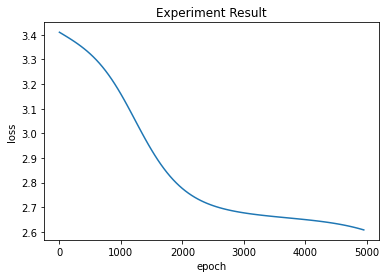

In [7]:
num_epochs = 5000
learning_rate = 0.0001

input_size = len(onehot_x[0])
hidden_size = 8
num_layers = 2
num_classes = len(onehot_x[0])

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

#classfication
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.001)

loss_ = [0]
epoch_ = [0]
accu_train = []
accu_test = []

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    
    optimizer.zero_grad()
    loss = criterion(outputs, trainY_l)      #trainY one-hot index
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        accu_train.append(evaluate(lstm, trainX, trainY_l))
        accu_test.append(evaluate(lstm, testX, testY_l))
        loss_.append(loss.item())
        epoch_.append(epoch)
   
plt.plot(epoch_[1:],loss_[1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Experiment Result')
plt.show()

Test

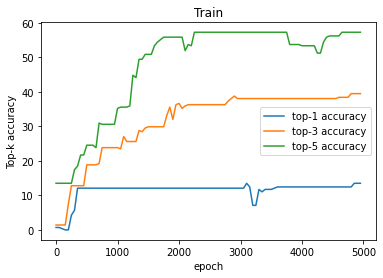

In [8]:
plt.plot(epoch_[1:],np.array(accu_train)[:,0], label='top-1 accuracy')
plt.plot(epoch_[1:],np.array(accu_train)[:,1], label='top-3 accuracy')
plt.plot(epoch_[1:],np.array(accu_train)[:,2], label='top-5 accuracy')
plt.xlabel('epoch')
plt.ylabel('Top-k accuracy')
plt.legend()
plt.title('Train')
plt.show()

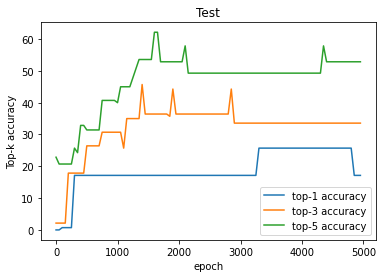

In [9]:
plt.plot(epoch_[1:],np.array(accu_test)[:,0], label='top-1 accuracy')
plt.plot(epoch_[1:],np.array(accu_test)[:,1], label='top-3 accuracy')
plt.plot(epoch_[1:],np.array(accu_test)[:,2], label='top-5 accuracy')
plt.xlabel('epoch')
plt.ylabel('Top-k accuracy')
plt.legend()
plt.title('Test')
plt.show()